In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import os

dataset was obtained from https://data.lacity.org/A-Well-Run-City/Parking-Citations/wjz9-h9np

In [6]:
filepath = os.path.dirname('__filename__')
fp_parking = os.path.join(filepath, 'dataset', 'Parking_Citations.csv') ## Path to dataset

In [9]:
## Just to see the format of the csv file
# with open(fp_parking, 'r') as f:
#     for n in range(3):
#         line = f.readline()
#         print(line)

Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,Color,Location,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude

4272349605,12/30/2015,2201,,,CA,201605,,OLDS,PA,GN,3069 SAN MARINO ST,00403,54,80.56E4+,RED ZONE,93,6471840.7,1842349.7

4272349616,12/30/2015,2205,,,CA,201508,,HOND,PA,WT,2936 8TH ST W,00403,54,80.56E1,WHITE ZONE,58,6473823.2,1843512



In [27]:
df = pd.read_csv(fp_parking, parse_dates=['Issue Date'])

In [33]:
df.info(memory_usage='deep', null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4038226 entries, 0 to 4038225
Data columns (total 19 columns):
Ticket number            4038226 non-null object
Issue Date               4037801 non-null datetime64[ns]
Issue time               4036941 non-null float64
Meter Id                 1125230 non-null object
Marked Time              141927 non-null float64
RP State Plate           4037223 non-null object
Plate Expiry Date        3686011 non-null float64
VIN                      16309 non-null object
Make                     4034020 non-null object
Body Style               4034392 non-null object
Color                    4036234 non-null object
Location                 4037672 non-null object
Route                    4011489 non-null object
Agency                   4037798 non-null float64
Violation code           4038226 non-null object
Violation Description    4037860 non-null object
Fine amount              4033923 non-null float64
Latitude                 4038226 non-null fl

## Find/Fix Errors

### Ticket Number

In [118]:
## The columns with mix column types
df.columns[[0]]

Index(['Ticket number'], dtype='object')

In [119]:
## One of the example why parsing Ticket number resulted in mix dtype
print("Example of Ticket number's parse error: {}".format(df.loc[595827, 'Ticket number']))
print("Number of parse errors: {}".format(\
    pd.to_numeric(df['Ticket number'], errors='coerce').isna().sum())) ## Count fail conversions

Example of Ticket number's parse error: 1107495524
Number of parse errors: 0


In [88]:
## Delete the letter D from number and convert to int value
df['Ticket number'] = pd.to_numeric(df['Ticket number'].str.replace('D', ''), downcast = 'unsigned')

In [117]:
## Make sure that ticket numbers are all unique
tmp = df.duplicated(subset='Ticket number', keep = False)
print('Number of Ticket number duplicates: {}'.format(tmp.sum()))

Number of duplicates: 8


In [115]:
df[tmp].sort_values(by = 'Ticket number')

,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,Color,Location,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude
1907370,1107505044,2015-04-12,1525.0,NaN,NaN,CA,201506.0,NaN,FORD,SU,BK,B-79 OUTER PKG LOT,M78,3.0,8709K,PK OVR PNTD LNS,58.0,99999.0,99999.0
1978540,1107505044,2015-04-30,2136.0,46,NaN,CA,201507.0,NaN,TOYO,PA,WH,122 N KINGSLEY DR,NaN,54.0,8058L,PREF PARKING,68.0,99999.0,99999.0
1968362,1107505055,2015-04-30,2147.0,46,NaN,CA,201507.0,NaN,FORD,TR,WH,200 N HOBART BL,NaN,54.0,8058L,PREF PARKING,68.0,99999.0,99999.0
2003185,1107505055,2015-04-21,1125.0,NaN,NaN,CA,NaN,NaN,HRI,TL,BK,500 N LECOUVREUR AVE,M78,3.0,80691A,COMM TRAILER/22 FT.,78.0,6483992.8,1740936.0
1285397,1111163222,2015-01-06,1655.0,NaN,NaN,CA,201501.0,NaN,CADI,PA,BK,10851 W OHIO AVE,00123,51.0,8069AP,NO STOP/STAND PM,93.0,6428251.9,1842411.5
1908101,1111163222,2015-04-17,646.0,NaN,NaN,CA,201502.0,NaN,HOND,PA,SI,3405 S OVERLAND AV,00146,51.0,8069C,PKD OVER TIME LIMIT,58.0,6436653.8,1832101.2
1037436,1112203050,2016-06-05,1700.0,NaN,NaN,CA,201604.0,NaN,HOND,PA,GY,7610 WOODLEY AVE,2C12,11.0,5204A,EXPIRED TAGS,25.0,6415432.1,1898663.3
1062722,1112203050,2016-06-19,319.0,NaN,NaN,CA,201601.0,NaN,KIA,PA,WH,301 WORLD WAY,3F93,2.0,4000A1,NO EVIDENCE OF REG,50.0,6437963.6,1802392.9


Cannot not find reasons for duplicate ticket number and since duplicates are such a small population and I have no good reason to correct them at the moment, I will keep them as is. 

## VIN

In [120]:
## VIN column isn't that useful because it is mainly null so keep as string
print("The number of non-null for VIN column: {:d}".format(df['VIN'].notnull().sum()))

The number of non-null for VIN column: 16309


## Issue Time

In [144]:
with pd.option_context('display.float_format', '{:.0f}'.format):
    print(df['Issue time'].describe())

count   4036941
mean       1224
std         477
min           0
25%         923
50%        1207
75%        1545
max        2359
Name: Issue time, dtype: float64


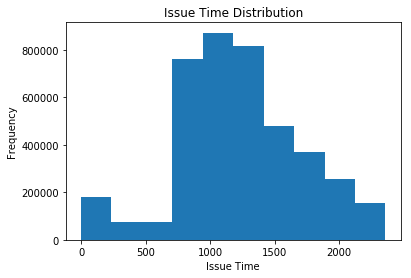

In [145]:
df['Issue time'].plot(kind = 'hist')
plt.title('Issue Time Distribution')
plt.xlabel('Issue Time')
plt.show()

Issue Time looks fine. There are no obvious wrong values. 

In [157]:
## Determine if Issue Time is truly a float or because of NaN
print("Number of floats: {}".format(sum(df['Issue time']%1 > 0)))
print('Number of nan: {}'.format(df['Issue time'].isna().sum()))

Number of floats: 0
Number of nan: 1285


## Meter Id

In [174]:
pd.Series(df['Meter Id'].unique()).describe()

count     34972
unique    34972
top       WH356
freq          1
dtype: object

In [226]:
## Not sure if these are weird meter id
meter_count = df.groupby('Meter Id').size()
meter_count = pd.DataFrame(meter_count)
meter_count.reset_index(inplace = True)
meter_count.columns = ['Meter Id', 'count']
meter_count[:10]

,Meter Id,count
0,!!,1
1,#1,284
2,#18,1
3,#2,604
4,#23,2
5,#24,53
6,#26,127
7,#49,7
8,#5,42
9,#52,23


In [185]:
## Found meter information 
## https://data.lacity.org/A-Well-Run-City/Parking-Meters-Citywide/sijn-eyig
## However it's for 2015 and last updated on 11/29/2016 so outdated
fp_meter = os.path.join(filepath, 'dataset', 'LADOT_Meters_Citywide_20151209.csv') ## Path to dataset
meter = pd.read_csv(fp_meter)
meter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34718 entries, 0 to 34717
Data columns (total 6 columns):
ADDRESS     34718 non-null object
METERID     34718 non-null object
LIMIT       34138 non-null object
the_geom    34718 non-null object
TYPE        34718 non-null object
HOURS       34316 non-null object
dtypes: object(6)
memory usage: 1.6+ MB


In [240]:
meterid = pd.DataFrame(meter.METERID.unique())
meterid.columns = ['Meter Id']
meterid['exist'] = True ## Indicator

In [245]:
## Full join with meter from parking citation with meter id from meter data
meter_exist = pd.merge(meter_count, meterid, how= 'outer')

In [285]:
## Return meters that doesn't exist in the meter dataset
meter_prob = meter_exist[meter_exist.exist.isna()].sort_values(by = 'count')[::-1]
print(meter_prob.shape[0])
## Find meter with the most count
meter_prob.head()

3124


,Meter Id,count,exist
355,37,23324.0,NaN
436,51,15400.0,NaN
450,53,13705.0,NaN
511,64,10918.0,NaN
117,13,10854.0,NaN


In [277]:
df[df['Meter Id'] == '37'].head()

,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,Color,Location,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude
1413,4272294585,2016-01-04,1806,37,NaN,AZ,201604.0,NaN,FORD,PA,GY,1666 SYCAMORE AVE N,00402,54.0,80.58L,PREFERENTIAL PARKING,68.0,6457731.2,1859366.8
1415,4272294600,2016-01-04,2156,37,NaN,CA,NaN,NaN,TOYT,PA,WT,7000 HAWTHORN AVE,00402,54.0,80.58L,PREFERENTIAL PARKING,68.0,6458312.4,1859071.2
1417,4272294622,2016-01-04,2205,37,NaN,CA,201608.0,NaN,LEXS,PA,BK,1666 SYCAMORE AVE N,00402,54.0,80.58L,PREFERENTIAL PARKING,68.0,6457731.2,1859366.8
1419,4272294644,2016-01-04,2216,37,NaN,CA,201604.0,NaN,FORD,PA,MR,1601 ORANGE DR,00402,54.0,80.58L,PREFERENTIAL PARKING,68.0,6458315.2,1858662.1
2721,4273416265,2016-01-04,1806,37,NaN,NV,201610.0,NaN,VOLK,PA,BK,1633 NORTH ORANGE DRIVE,00401,54.0,80.58L,PREFERENTIAL PARKING,68.0,6458312.4,1859071.2


In [284]:
df[df['Meter Id'] == '37'].Location.unique().shape

(1907,)

It doesn't look like meter id is a very reliable source because the ID and addresses do not match. In fact for Meter Id 37 there is 1907 different addresses. So for now, just leave it as is. 

## Marked Time

In [291]:
df[df['Marked Time'].notnull()]['Violation Description'].unique()

array(['PARKED OVER TIME LIM', 'PREFERENTIAL PARKING',
       'COMM VEH OVER TIME L', 'PARKED OVER TIME LIMIT'], dtype=object)

In [294]:
df['Marked Time'].describe()

count    141927.000000
mean       1067.866572
std         225.536345
min           1.000000
25%         925.000000
50%        1042.000000
75%        1205.000000
max        2400.000000
Name: Marked Time, dtype: float64

So Marked Time means when the car was first marked to be timed as for how long it has been at that parking spot.

The feature looks fine. 

## RP State Plate

In [339]:
state_plate = pd.DataFrame(df.groupby('RP State Plate').size().sort_values())
state_plate.reset_index(inplace = True)
state_plate.columns = ['state', 'number']
state_plate.head(3)

,state,number
0,|,2
1,PR,5


In [326]:
## USA States and Territories
states = {"AL":"Alabama","AK":"Alaska","AS":"American Samoa","AZ":"Arizona","AR":"Arkansas",
          "CA":"California","CO":"Colorado","CT":"Connecticut","DE":"Delaware",
          "DC":"District Of Columbia","FM":"Federated States Of Micronesia","FL":"Florida",
          "GA":"Georgia","GU":"Guam","HI":"Hawaii","ID":"Idaho","IL":"Illinois","IN":"Indiana",
          "IA":"Iowa","KS":"Kansas","KY":"Kentucky","LA":"Louisiana","ME":"Maine",
          "MH":"Marshall Islands","MD":"Maryland","MA":"Massachusetts","MI":"Michigan",
          "MN":"Minnesota","MS":"Mississippi","MO":"Missouri","MT":"Montana","NE":"Nebraska",
          "NV":"Nevada","NH":"New Hampshire","NJ":"New Jersey","NM":"New Mexico","NY":"New York",
          "NC":"North Carolina","ND":"North Dakota","MP":"Northern Mariana Islands","OH":"Ohio",
          "OK":"Oklahoma","OR":"Oregon","PW":"Palau","PA":"Pennsylvania","PR":"Puerto Rico",
          "RI":"Rhode Island","SC":"South Carolina","SD":"South Dakota","TN":"Tennessee",
          "TX":"Texas","UT":"Utah","VT":"Vermont","VI":"Virgin Islands","VA":"Virginia",
          "WA":"Washington","WV":"West Virginia","WI":"Wisconsin","WY":"Wyoming"}
states = pd.DataFrame.from_dict(states, orient = 'index')
states.reset_index(inplace = True)
states.columns = ['abbr', 'name']
states.head(3)

,abbr,name
0,AL,Alabama
1,AK,Alaska
2,AS,American Samoa
3,AZ,Arizona
4,AR,Arkansas


In [343]:
## State Plate that doesn't exist in states list
state_comb = pd.merge(state_plate, states, how = 'outer', left_on='state', right_on='abbr')
state_unknown = state_comb[state_comb.name.isna()]
state_unknown

,state,number,abbr,name
0,|,2.0,NaN,NaN
2,NF,5.0,NaN,NaN
3,YU,7.0,NaN,NaN
4,PE,9.0,NaN,NaN
5,NW,9.0,NaN,NaN
7,TT,12.0,NaN,NaN
10,CZ,22.0,NaN,NaN
11,NS,46.0,NaN,NaN
12,XX,54.0,NaN,NaN
13,SA,73.0,NaN,NaN


I think MX is Mexico plate because LA is pretty close to Mexico so it is possible and likely. Or a misspelling for MS because s is close to x on the keyboard. 

In [344]:
state_comb.query("state == 'MS'")

,state,number,abbr,name
35,MS,1065.0,MS,Mississippi


In [337]:
state_plate.reset_index(inplace = True)

In [338]:
state_plate.head()

,RP State Plate,0
0,|,2
1,PR,5
2,NF,5
3,YU,7
4,PE,9


## Data Compression

In [163]:
## Remove nan from Issue Time by setting it to -1
df.loc[df['Issue time'].isna(),'Issue time'] = -1 
## Convert column into integer
df['Issue time'] = pd.to_numeric(df['Issue time'], downcast = 'integer')

In [296]:
## Remove nan from Marked Time by setting it to -1 
df.loc[df['Marked Time'].isna(), 'Marked Time'] = -1
df['Marked Time'] = pd.to_numeric(df['Marked Time'], downcast = 'integer')

In [297]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4038226 entries, 0 to 4038225
Data columns (total 19 columns):
Ticket number            int64
Issue Date               datetime64[ns]
Issue time               int16
Meter Id                 object
Marked Time              int16
RP State Plate           object
Plate Expiry Date        float64
VIN                      object
Make                     object
Body Style               object
Color                    object
Location                 object
Route                    object
Agency                   float64
Violation code           object
Violation Description    object
Fine amount              float64
Latitude                 float64
Longitude                float64
dtypes: datetime64[ns](1), float64(5), int16(2), int64(1), object(10)
memory usage: 2.4 GB


TODO: 
* change the names of the columns for easier usage
* export pandas data for later processsing
* compress the data as much as possible

random testing

In [15]:
np.iinfo('int8')

iinfo(min=-128, max=127, dtype=int8)

In [94]:
np.iinfo('uint32')

iinfo(min=0, max=4294967295, dtype=uint32)

In [91]:
np.iinfo(1107434506)

iinfo(min=-2147483648, max=2147483647, dtype=int32)

In [ ]:
np.iinfo('uint8')